# Understanding Diffusion Models

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F

from matplotlib import pyplot as plt
from PIL import Image
from datasets import load_dataset
from torchvision import transforms
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Utils to show images and make grids

In [2]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

### Dataset

In [3]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# We'll train on 32-pixel square images
image_size = 32
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Repo card metadata block was not found. Setting CardData to empty.


X shape: torch.Size([8, 3, 32, 32])


/var/folders/18/m5t215b91099mhnt7b5bl5sr0000gn/T/ipykernel_77631/387830730.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


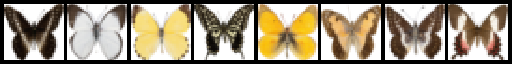

In [4]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

## Diffusion model

#### Forward diffusion process

In [5]:
from diffusers import DDPMScheduler, DDIMScheduler # We can also use DDPM scheduler, but this is slower

timesteps = 1000
noise_scheduler = DDIMScheduler(num_train_timesteps=timesteps, beta_schedule='squaredcos_cap_v2')

The forward diffusion process progressively adds noise to the original image $\mathbf{x}_0$ as timestep $t$ increases.

The process is defined by the re-parameterization formula:

$$
q(\mathbf{x}_t \mid \mathbf{x}_0)
    = \mathcal{N}\!\bigl(
        \mathbf{x}_t;\,
        \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0,\,
        (1 - \bar{\alpha}_t)\,\mathbf{I}
      \bigr)
$$

where:

* $\mathbf{x}_t$ — noisy image at timestep $t$  
* $\sqrt{\bar{\alpha}_t}$ — scales down the original image  
* $1-\bar{\alpha}_t$ — variance of the added Gaussian noise

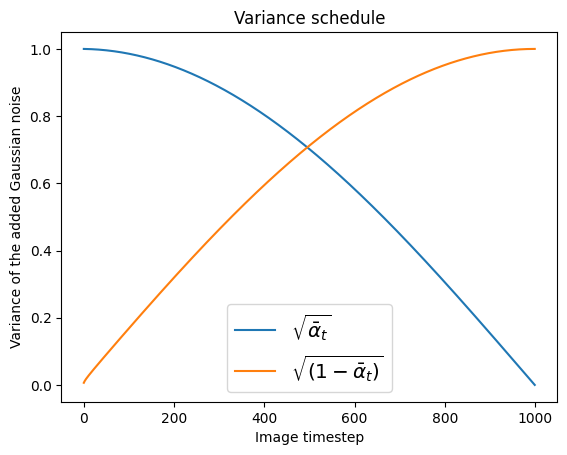

In [6]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");
plt.title("Variance schedule")
plt.xlabel("Image timestep")
plt.ylabel("Variance of the added Gaussian noise")
plt.show()

The more time steps, the more noise is added to the original image $\mathbf{x}_0$

In [7]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999])

The following images demonstrate the progressive addition of noise to the original image $\mathbf{x}_0$ across different timesteps. The sequence shows a gradual transition from minimal noise in the initial images to almost complete noise in the final image.

Noisy X shape torch.Size([8, 3, 32, 32])


/var/folders/18/m5t215b91099mhnt7b5bl5sr0000gn/T/ipykernel_77631/387830730.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


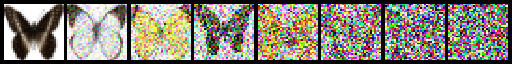

In [8]:
noise = torch.randn_like(xb) # same shape as xb: [Batch size, Channels, Height, Width]

noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

#### Training

U-nets allow to predict images of the same size as the input image

In [9]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # input channels: 3 for RGB images
    out_channels=3,  # output channels: 3 for RGB images
    layers_per_block=2,  # number of ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=( # This makes reference to the downsampling blocks
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=( # This makes reference to the upsampling blocks
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [14]:
# Set the noise scheduler
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
epochs = 16

losses = []

for epoch in tqdm(range(epochs), desc="Epochs"):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 2 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch: {epoch+1}, loss: {loss_last_epoch}")

Epochs:   0%|          | 0/16 [00:00<?, ?it/s]/Users/adrianaorellana/anaconda3/envs/diffusion_arcade/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epochs:  12%|█▎        | 2/16 [01:57<13:39, 58.57s/it]

Epoch: 2, loss: 0.11958991456776857


Epochs:  25%|██▌       | 4/16 [03:53<11:40, 58.37s/it]

Epoch: 4, loss: 0.09832679200917482


Epochs:  38%|███▊      | 6/16 [05:49<09:42, 58.25s/it]

Epoch: 6, loss: 0.08852624869905412


Epochs:  50%|█████     | 8/16 [07:46<07:46, 58.27s/it]

Epoch: 8, loss: 0.08383235381916165


Epochs:  62%|██████▎   | 10/16 [09:43<05:49, 58.25s/it]

Epoch: 10, loss: 0.07944169663824141


Epochs:  75%|███████▌  | 12/16 [11:38<03:51, 57.88s/it]

Epoch: 12, loss: 0.07260145735926926


Epochs:  88%|████████▊ | 14/16 [13:32<01:55, 57.52s/it]

Epoch: 14, loss: 0.07268462888896465


Epochs: 100%|██████████| 16/16 [15:30<00:00, 58.17s/it]

Epoch: 16, loss: 0.06547536444850266


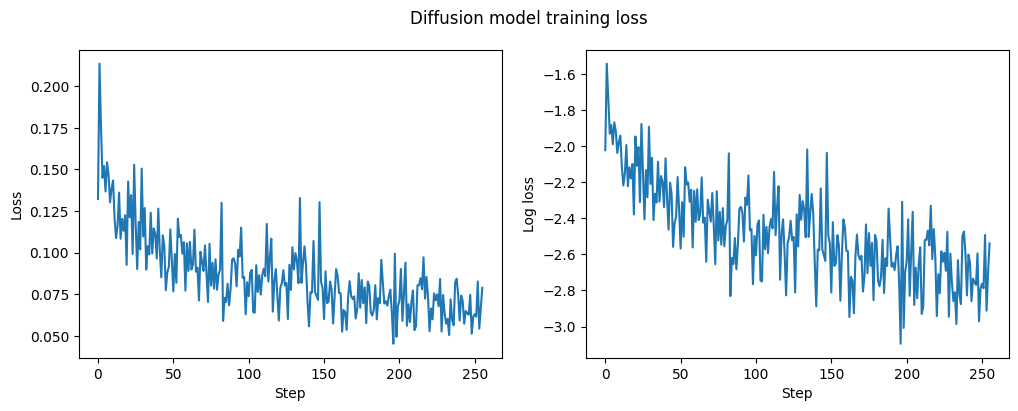

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
fig.suptitle("Diffusion model training loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Log loss")
plt.show()

#### Generating images

torch.Size([8, 3, 32, 32])


/var/folders/18/m5t215b91099mhnt7b5bl5sr0000gn/T/ipykernel_77631/387830730.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


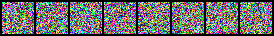

In [19]:
# Setting the number of timesteps for inference (this is only applicable for DDIM scheduler)
noise_scheduler.set_timesteps(50)

# Generate random noise for 8 images
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = model(sample, t).sample

    sample = noise_scheduler.step(residual, t, sample).prev_sample
    print(sample.shape)
    break

show_images(sample)

## References

1. **Hugging Face Diffusion Course, Unit 0: Introduction to Diffusion Models**  
   Available online: [https://huggingface.co/learn/diffusion-course/en/unit0/1](https://huggingface.co/learn/diffusion-course/en/unit0/1)

2. **Ho, J., Jain, A., & Abbeel, P.** (2020). *Denoising Diffusion Probabilistic Models*.  
   arXiv preprint arXiv:2006.11239. [PDF](https://arxiv.org/pdf/2006.11239)

3. **Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B.** (2022). *High-Resolution Image Synthesis with Latent Diffusion Models*.  
   arXiv preprint arXiv:2208.11970. [PDF](https://arxiv.org/pdf/2208.11970)
